### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
from warnings import filterwarnings
warnings.simplefilter(action='ignore')
%matplotlib inline

### Import Dataset

The data is a 10 years apple stock price dataset from November 2018 to November 2023, downloaded from: https://finance.yahoo.com/quote/AAPL/history?period1=1542758400&period2=1700524800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true 

In [3]:
data = pd.read_csv('AAPL_10y.csv', parse_dates=True)

In [4]:
df = pd.DataFrame(data)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-22,18.554285,18.648571,18.518929,18.564285,16.275156,223725600
1,2013-11-25,18.607857,18.781071,18.607143,18.705000,16.398514,229311600
2,2013-11-26,18.718571,19.147858,18.714287,19.049999,16.700972,401382800
3,2013-11-27,19.153929,19.500000,19.049999,19.498571,17.094225,363448400
4,2013-11-29,19.624287,19.940357,19.564644,19.859644,17.410786,318127600
...,...,...,...,...,...,...,...
2511,2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500
2512,2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900
2513,2023-11-17,190.250000,190.380005,188.570007,189.690002,189.690002,50922700
2514,2023-11-20,189.889999,191.910004,189.880005,191.449997,191.449997,46505100


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2516.0,7.606341e+01,5.521721e+01,1.768500e+01,2.938000e+01,4.743000e+01,1.324600e+02,1.962400e+02
High,2516.0,7.690204e+01,5.586808e+01,1.791178e+01,2.959938e+01,4.787250e+01,1.340975e+02,1.982300e+02
Low,2516.0,7.527897e+01,5.462075e+01,1.762679e+01,2.914938e+01,4.695125e+01,1.310775e+02,1.952800e+02
Close,2516.0,7.612758e+01,5.527502e+01,1.784928e+01,2.939688e+01,4.751500e+01,1.323175e+02,1.964500e+02
Adj Close,2516.0,7.416664e+01,5.575089e+01,1.564832e+01,2.698562e+01,4.542918e+01,1.309142e+02,1.959270e+02
Volume,2516.0,1.395661e+08,8.640780e+07,3.145820e+07,8.267175e+07,1.137230e+08,1.696505e+08,1.065523e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2516 non-null   object 
 1   Open       2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Close      2516 non-null   float64
 5   Adj Close  2516 non-null   float64
 6   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


In [7]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
# checking the data for null or NA value
isNull = df.isnull().sum().to_frame(name='isNull').T
isNa = df.isna().sum().to_frame(name='isNa').T
Unique = df.nunique().to_frame(name='Unique').T
summary = pd.concat([Unique, isNa, isNull])
summary

,Date,Open,High,Low,Close,Adj Close,Volume
Unique,2516,2379,2369,2383,2368,2477,2508
isNa,0,0,0,0,0,0,0
isNull,0,0,0,0,0,0,0


In [9]:
df.duplicated().sum()

0

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-22,18.554285,18.648571,18.518929,18.564285,16.275156,223725600
2013-11-25,18.607857,18.781071,18.607143,18.705000,16.398514,229311600
2013-11-26,18.718571,19.147858,18.714287,19.049999,16.700972,401382800
2013-11-27,19.153929,19.500000,19.049999,19.498571,17.094225,363448400
2013-11-29,19.624287,19.940357,19.564644,19.859644,17.410786,318127600
...,...,...,...,...,...,...
2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500
2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900
2023-11-17,190.250000,190.380005,188.570007,189.690002,189.690002,50922700


### Exploratory Data Analysis

In [11]:
font1 = {'family':'serif','size':18}
font2 = {'family':'serif','size':15}
font3 = {'family':'serif','size':13}

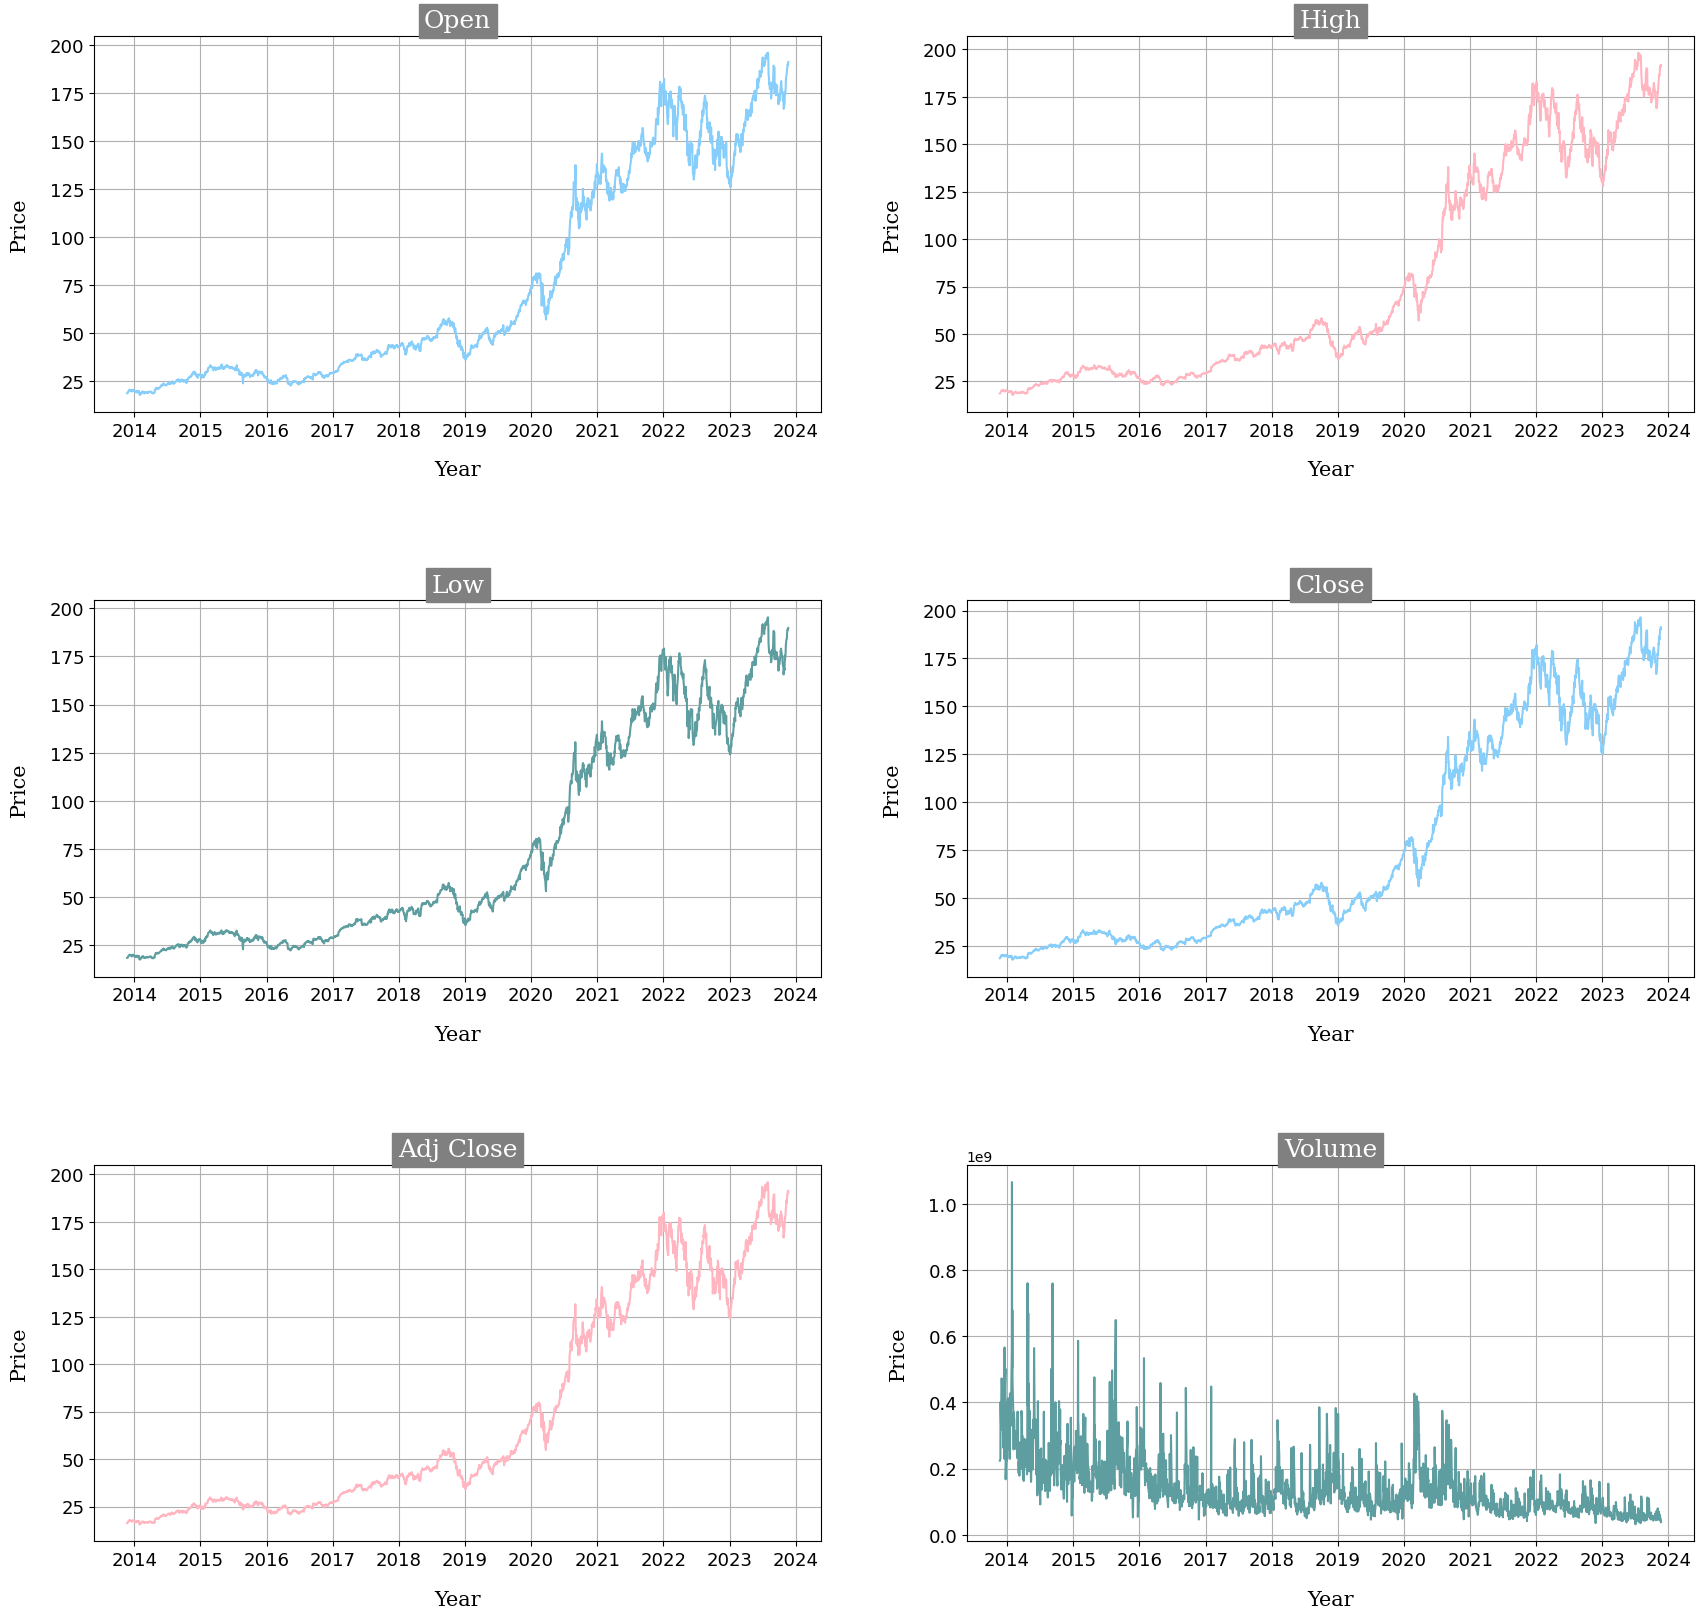

In [12]:
# plot the features of the stock price

colors =['blue','Red', 'Yellow','turquoise','blue','Red', 'Yellow','turquoise', 'blue','Red', 'Yellow','turquoise']
colors= ['lightskyblue' , 'lightpink' , 'cadetblue','lightskyblue' , 'lightpink' , 'cadetblue','lightskyblue' , 'lightpink' , 'cadetblue','lightskyblue' , 'lightpink' , 'cadetblue']
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(40)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.5)
i=1
for column in df.columns: 
    plt.subplot(6,2,i)
    plt.plot(df[column], color=colors[i-1])
    plt.title(column,backgroundcolor='grey',color='white',fontdict=font1)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Year',fontdict=font2,labelpad=15)
    plt.ylabel("Price",fontdict=font2,labelpad=15)
    plt.grid()
    i+=1

In [13]:
df2 = df.drop(columns=['Volume'])

Text(0, 0.5, 'Price')

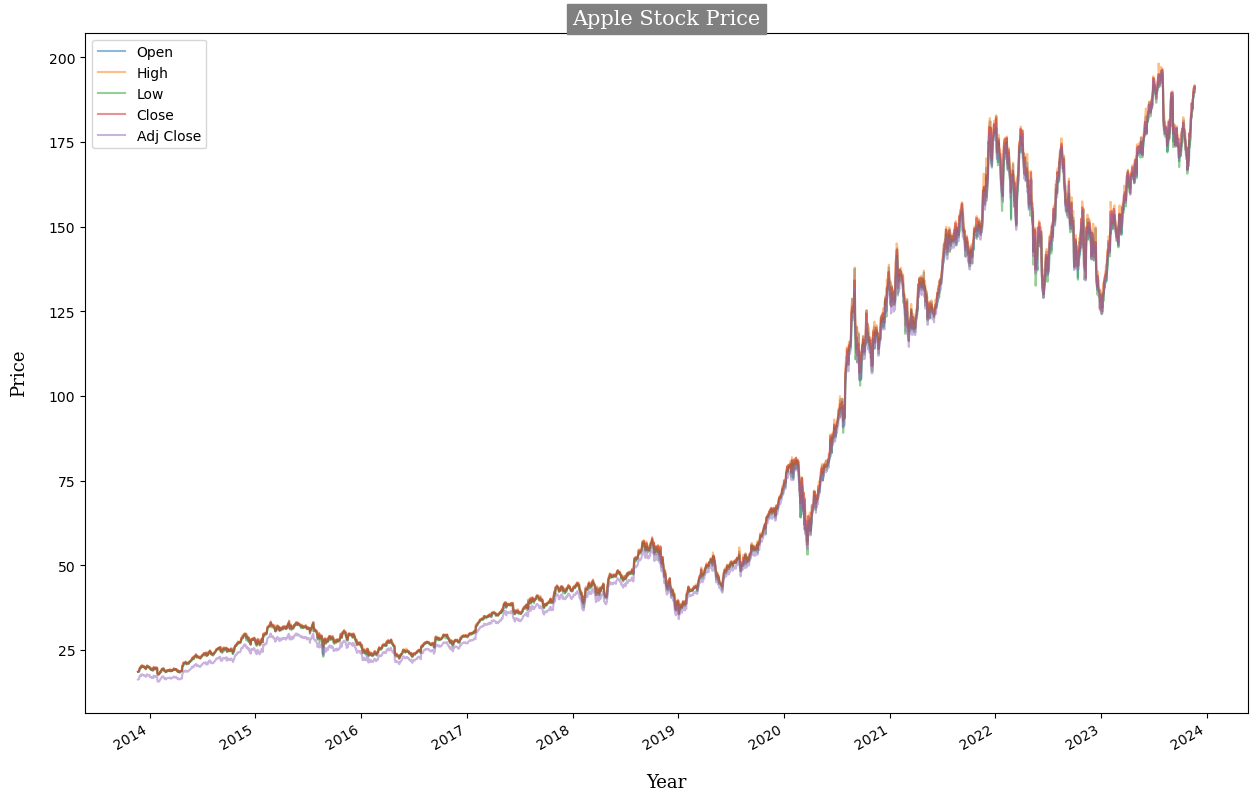

In [107]:
fig, ax = plt.subplots(figsize=(15, 10))
df2.plot(ax=ax, alpha=0.5)
ax.set_title('Apple Stock Price', backgroundcolor='grey',color='white',fontdict=font2)
ax.set_xlabel('Year',fontdict=font3,labelpad=15)
ax.set_ylabel('Price',fontdict=font3,labelpad=15)

By utilizing rolling techniques such as 6-day, 30-day, and 60-day rolling averages, this visualization provides insights into the impact of moving averages on price trends over time. Gain a comprehensive understanding of how rolling averages influence the behavior of financial data in this informative exploration of closing prices and their trends.

In [15]:
W6 = df.rolling(window=6).mean()
W30 = df.rolling(window=30).mean()
W60 = df.rolling(window=60).mean()

Explore the dynamic relationship between closing prices and trend patterns through the application of rolling averages in this analysis:

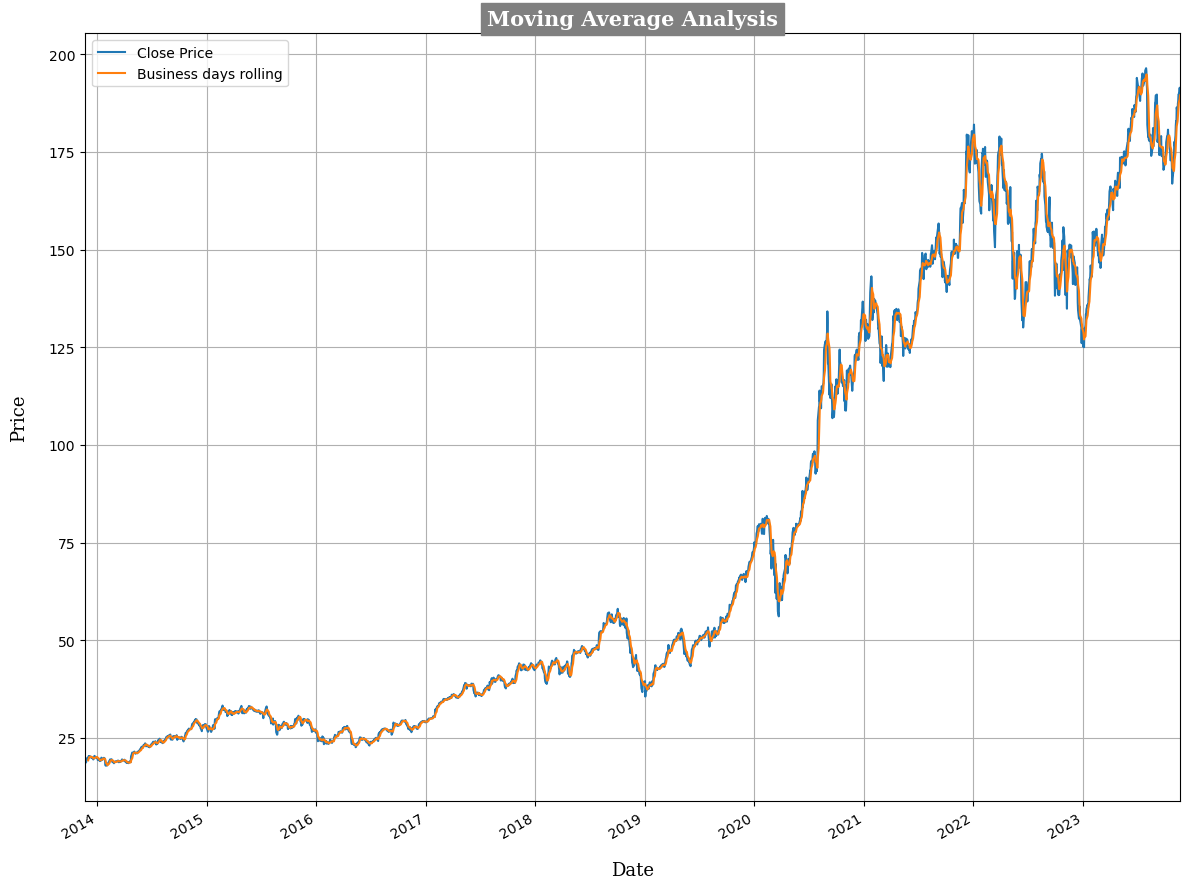

In [16]:
plt.figure(figsize=(12, 9))
df['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
W6['Close'].plot(label='Business days rolling').autoscale(axis='x',tight=True)


plt.legend()
plt.title('Moving Average Analysis',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

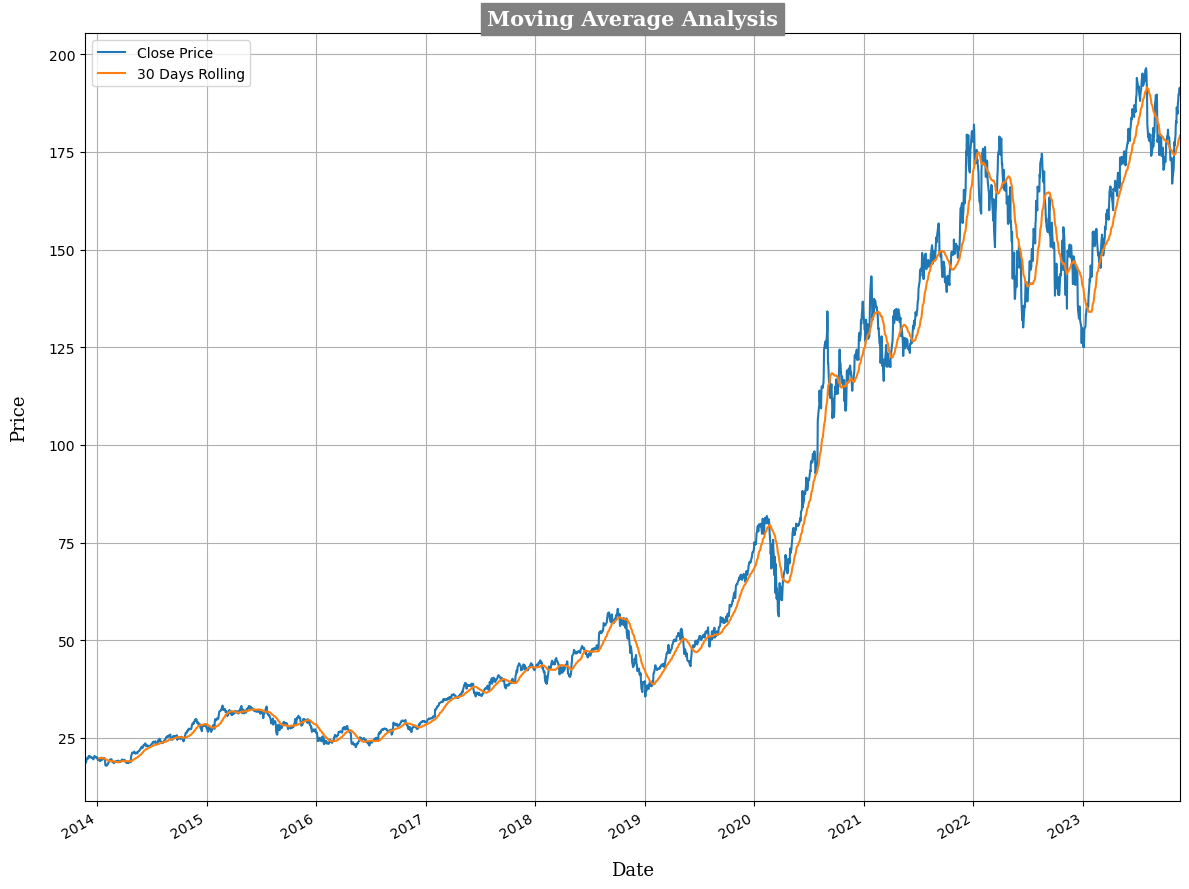

In [17]:
plt.figure(figsize=(12, 9))
df['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
W30['Close'].plot(label='30 Days Rolling').autoscale(axis='x',tight=True)


plt.legend()
plt.title('Moving Average Analysis',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

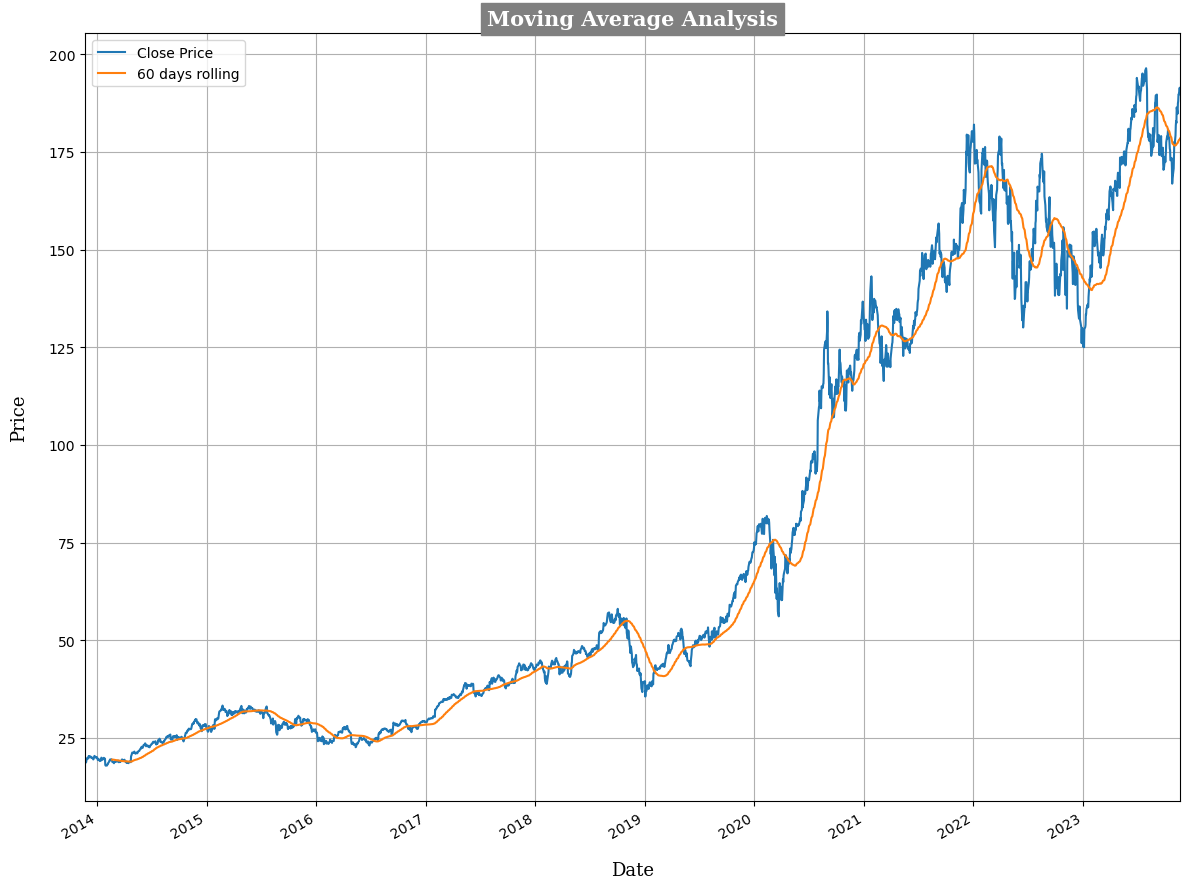

In [18]:
plt.figure(figsize=(12, 9))
df['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
W60['Close'].plot(label='60 days rolling').autoscale(axis='x',tight=True)


plt.legend()
plt.title('Moving Average Analysis',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

### Preparing the dataset
### Normalising the data

In [19]:
DF = df[['Open', 'High', 'Low', 'Close']]

In [20]:
scaler = MinMaxScaler()
DF[DF.columns] = scaler.fit_transform(DF)
DF.shape

(2516, 4)

### Split the data into Train, Test and Validation data

In [21]:
# the data will be split into 80:10:10 ratio for training, validation, and test sets
training_size = round(len(DF) * 0.80)
validation_size = round(len(DF) * 0.10)

train_data = DF.iloc[:training_size, 0:4]
val_data = DF.iloc[training_size:training_size + validation_size, 0:4]
test_data = DF.iloc[training_size + validation_size:, 0:4]

train_data.shape, val_data.shape, test_data.shape


((2013, 4), (252, 4), (251, 4))

### Create training data sequences and labels

In [22]:
def prepare_time_series_data(Data, window_size):
    #Creates sequences of data and corresponding labels for training and testing. 
  sequences = []
  labels = []
  i = 0

  for j in range(window_size,len(Data)):
    sequences.append(Data.iloc[i:j])
    labels.append(Data.iloc[j])
    i += 1
    
  return np.array(sequences),np.array(labels)

### Dataset and models for window size = 6 days

In [23]:
X_train6, y_train6 = prepare_time_series_data(train_data,6)
X_test6, y_test6 = prepare_time_series_data(test_data,6)
X_val6, y_val6 = prepare_time_series_data(val_data,6)

In [24]:
X_train6.shape, y_train6.shape, X_test6.shape, y_test6.shape, X_val6.shape, y_val6.shape

((2007, 6, 4), (2007, 4), (245, 6, 4), (245, 4), (246, 6, 4), (246, 4))

### Modeling
### Model 1: Simple LSTM model with window size = 6

In [25]:
length = 6
LSTM1_W6 = Sequential()

LSTM1_W6.add(LSTM(100, return_sequences=True, input_shape=(length, X_train6.shape[2])))
LSTM1_W6.add(Dropout(0.2))
LSTM1_W6.add(LSTM(100, return_sequences=False, input_shape=(length, X_train6.shape[2])))
LSTM1_W6.add(Dropout(0.2))
LSTM1_W6.add(Dense(X_train6.shape[2]))

# compile the model
LSTM1_W6.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

2023-11-24 18:17:13.891271: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-24 18:17:13.891321: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-24 18:17:13.891402: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-24 18:17:13.891544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 18:17:13.891591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
LSTM1_W6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 100)            42000     
                                                                 
 dropout (Dropout)           (None, 6, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 122804 (479.70 KB)
Trainable params: 122804 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
early_stop = EarlyStopping(monitor='loss', patience=5)

In [28]:
# fit the model with 50 epochs
LSTM1_W6.fit(X_train6, y_train6, epochs=50, validation_data=(X_val6, y_val6), batch_size=32, callbacks=[early_stop])

Epoch 1/50


2023-11-24 18:17:18.290259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 26ms/step - loss: 0.0082 - mean_absolute_error: 0.0485 - val_loss: 0.0019 - val_mean_absolute_error: 0.0361
Epoch 2/50
63/63 [==============================] - 1s 16ms/step - loss: 6.6625e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0031 - val_mean_absolute_error: 0.0486
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 4.0417e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0017 - val_mean_absolute_error: 0.0336
Epoch 4/50
63/63 [==============================] - 1s 16ms/step - loss: 2.4277e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0044 - val_mean_absolute_error: 0.0591
Epoch 5/50
63/63 [==============================] - 1s 16ms/step - loss: 1.7629e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0012 - val_mean_absolute_error: 0.0278
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 1.5724e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 7/50
63

### Visualising Model Metrics

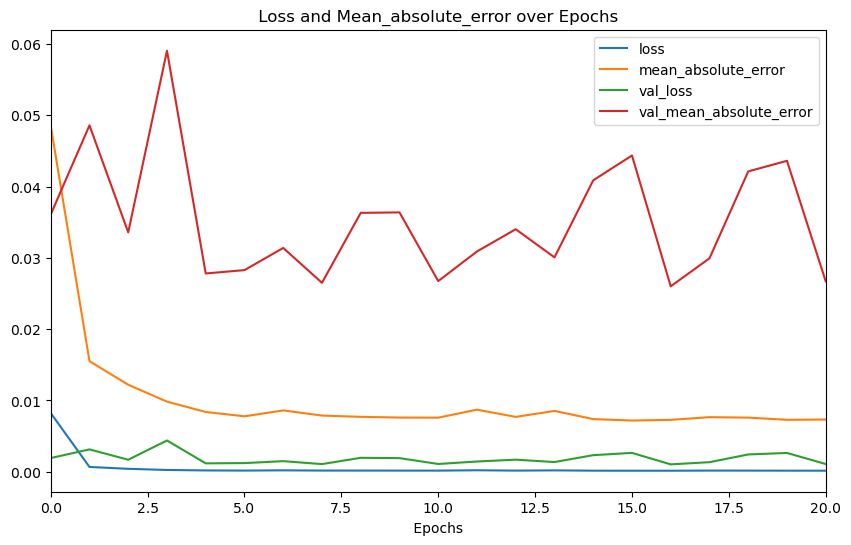

In [30]:
title=' Loss and Mean_absolute_error over Epochs '

xlabel=' Epochs '

LSTM1_W6_losses = pd.DataFrame(LSTM1_W6.history.history)
ax = LSTM1_W6_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [31]:
def highlight_best(data):
    data_highlighted = data.copy()
    min_loss = data_highlighted['loss'].min()
    min_mae = data_highlighted['mean_absolute_error'].min()
    min_val_loss = data_highlighted['val_loss'].min()
    min_val_mae = data_highlighted['val_mean_absolute_error'].min()
    # Create boolean masks to identify the maximum values
    min_loss = data_highlighted['loss'] == min_loss
    min_mae = data_highlighted['mean_absolute_error'] == min_mae
    min_val_loss = data_highlighted['val_loss'] == min_val_loss
    min_val_mae = data_highlighted['val_mean_absolute_error'] == min_val_mae
    # Apply a custom highlighting style to the maximum values using CSS
    data_highlighted = data_highlighted.style.apply(lambda x: ['background: yellow' if v else '' for v in min_loss],
                subset=['loss']).apply(lambda x: ['background: yellow' if v else '' for v in min_mae],
                subset=['mean_absolute_error']).apply(lambda x: ['background: yellow' if v else '' for v in min_val_loss],
                subset=['val_loss']).apply(lambda x: ['background: yellow' if v else '' for v in min_val_mae],
                                                    subset=['val_mean_absolute_error'])
    
    return data_highlighted

In [32]:
highlighted_LSTM1_W6_losses = highlight_best(LSTM1_W6_losses)
highlighted_LSTM1_W6_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.008226,0.048548,0.001915,0.036085
1,0.000666,0.015510,0.003130,0.048593
2,0.000404,0.012197,0.001676,0.033576
3,0.000243,0.009828,0.004379,0.059065
4,0.000176,0.008379,0.001170,0.027814
5,0.000157,0.007770,0.001207,0.028282
6,0.000189,0.008596,0.001478,0.031393
7,0.000159,0.007876,0.001067,0.026501
8,0.000157,0.007696,0.001948,0.036316
9,0.000152,0.007595,0.001903,0.036382


### Evaluation of the first LSTM model on test data

In [33]:
def predict_and_inverse_transform(DF, X_test, model, scaler):
    
    test = DF.iloc[-len(X_test):].copy()
    
    predictions = model.predict(X_test)
    inverse_predictions = scaler.inverse_transform(predictions)
    inverse_predictions = pd.DataFrame(inverse_predictions,columns=['Predicted Close', 'Predicted High',
                        'Predicted Low', 'Predicted Open'],index=DF.iloc[-len(X_test):].index)
    
    test_df = pd.concat([test.copy(), inverse_predictions], axis=1)
    test_df[['Open', 'High', 'Low', 'Close']] = scaler.inverse_transform(test_df[['Open', 'High', 'Low', 'Close']])
    
    return test_df

In [34]:
test_df_LSTM1_W6 = predict_and_inverse_transform(DF, X_test6, LSTM1_W6, scaler)

8/8 [==============================] - 0s 8ms/step


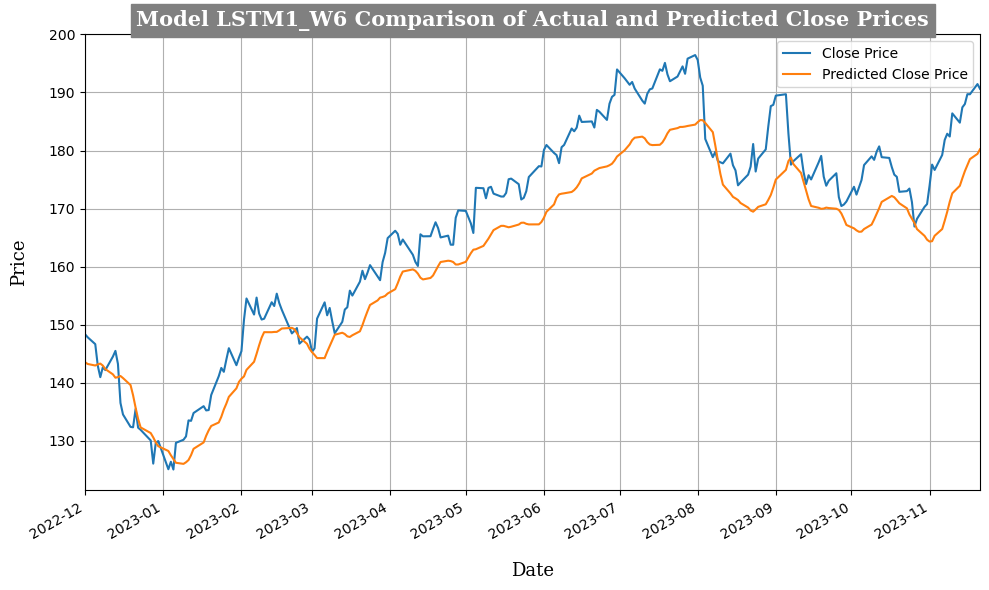

In [108]:
plt.figure(figsize=(10, 6))
test_df_LSTM1_W6['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df_LSTM1_W6['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM1_W6 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()

### Model 2: Second LSTM model with window size = 6

In [38]:
LSTM2_W6 = Sequential()

# First LSTM layer
LSTM2_W6.add(LSTM(150, input_shape=(length,X_train6.shape[2]), return_sequences=True))
LSTM2_W6.add(Dropout(0.2))

# Second LSTM layer
LSTM2_W6.add(LSTM(100, input_shape=(length,X_train6.shape[2]), return_sequences=True))
LSTM2_W6.add(Dropout(0.2))

# Third LSTM layer 
LSTM2_W6.add(LSTM(100, input_shape=(length,X_train6.shape[2]), return_sequences=False)) 
LSTM2_W6.add(Dropout(0.2))

# Final Prediction (one neuron per feature)
LSTM2_W6.add(Dense(units=50))
LSTM2_W6.add(Dense(units=5))
LSTM2_W6.add(Dense(X_train6.shape[2]))

LSTM2_W6.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [39]:
LSTM2_W6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 150)            93000     
                                                                 
 dropout_3 (Dropout)         (None, 6, 150)            0         
                                                                 
 lstm_5 (LSTM)               (None, 6, 100)            100400    
                                                                 
 dropout_4 (Dropout)         (None, 6, 100)            0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)               

In [41]:
LSTM2_W6.fit(X_train6, y_train6,epochs=50,validation_data=(X_val6, y_val6),batch_size = 32,callbacks=[early_stop],verbose=1)

Epoch 1/50
63/63 [==============================] - 4s 36ms/step - loss: 0.0114 - mean_absolute_error: 0.0528 - val_loss: 0.0015 - val_mean_absolute_error: 0.0318
Epoch 2/50
63/63 [==============================] - 1s 21ms/step - loss: 4.4808e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0015 - val_mean_absolute_error: 0.0310
Epoch 3/50
63/63 [==============================] - 1s 21ms/step - loss: 2.7687e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0032 - val_mean_absolute_error: 0.0460
Epoch 4/50
63/63 [==============================] - 1s 21ms/step - loss: 3.0000e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0019 - val_mean_absolute_error: 0.0359
Epoch 5/50
63/63 [==============================] - 1s 22ms/step - loss: 2.2618e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0031 - val_mean_absolute_error: 0.0461
Epoch 6/50
63/63 [==============================] - 1s 21ms/step - loss: 3.0672e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0019 - val_mean_absolute_error: 0.0356
Ep

### Visualising model metrics

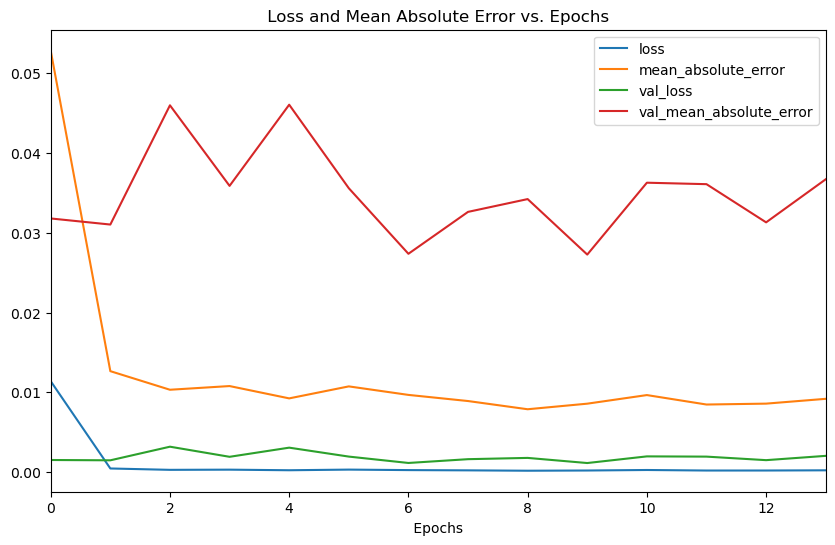

In [42]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
LSTM2_W6_losses = pd.DataFrame(LSTM2_W6.history.history)

ax = LSTM2_W6_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [43]:
highlighted_LSTM2_W6_losses = highlight_best(LSTM2_W6_losses)
highlighted_LSTM2_W6_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.011391,0.052831,0.001511,0.031798
1,0.000448,0.012651,0.001472,0.031035
2,0.000277,0.010320,0.003180,0.045987
3,0.000300,0.010783,0.001912,0.035884
4,0.000226,0.009238,0.003059,0.046060
5,0.000307,0.010742,0.001938,0.035591
6,0.000245,0.009674,0.001140,0.027369
7,0.000213,0.008904,0.001615,0.032623
8,0.000167,0.007875,0.001774,0.034227
9,0.000194,0.008574,0.001131,0.027269


### Evaluation of the second LSTM model on test data

In [44]:
test_df2_LSTM2_W6 = predict_and_inverse_transform(DF, X_test6, LSTM2_W6, scaler)

8/8 [==============================] - 1s 16ms/step


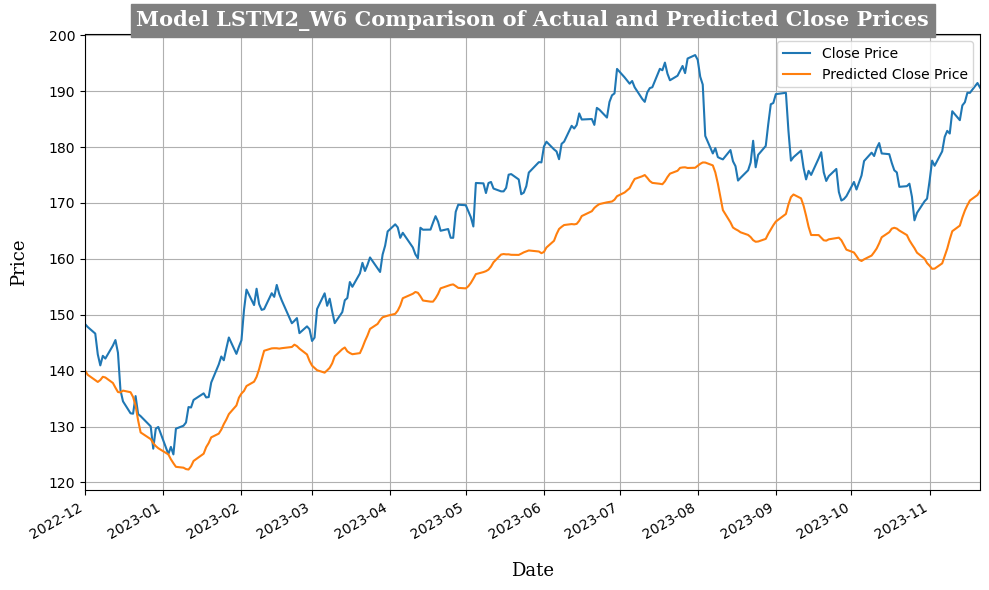

In [109]:
plt.figure(figsize=(10, 6))
test_df2_LSTM2_W6['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df2_LSTM2_W6['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM2_W6 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 3: GRU Model with window size = 6

In [47]:
GRU_Model_W6 = Sequential()

# add a GRU layer with input_shape
GRU_Model_W6.add(GRU(128, input_shape=(length, X_train6.shape[2]), activation='tanh'))

# add the final dense layer
GRU_Model_W6.add(Dense(X_train6.shape[2]))

# compile the model
GRU_Model_W6.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [48]:
GRU_Model_W6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               51456     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 51972 (203.02 KB)
Trainable params: 51972 (203.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
GRU_Model_W6.fit(X_train6, y_train6, epochs=50,validation_data=(X_val6, y_val6),batch_size = 32,callbacks=[early_stop],verbose=1)


Epoch 1/50
63/63 [==============================] - 2s 19ms/step - loss: 0.0083 - mean_absolute_error: 0.0429 - val_loss: 7.5319e-04 - val_mean_absolute_error: 0.0220
Epoch 2/50
63/63 [==============================] - 1s 9ms/step - loss: 8.4274e-05 - mean_absolute_error: 0.0055 - val_loss: 6.3393e-04 - val_mean_absolute_error: 0.0205
Epoch 3/50
63/63 [==============================] - 1s 9ms/step - loss: 8.2698e-05 - mean_absolute_error: 0.0054 - val_loss: 6.0013e-04 - val_mean_absolute_error: 0.0200
Epoch 4/50
63/63 [==============================] - 1s 9ms/step - loss: 8.5906e-05 - mean_absolute_error: 0.0055 - val_loss: 6.2391e-04 - val_mean_absolute_error: 0.0204
Epoch 5/50
63/63 [==============================] - 1s 9ms/step - loss: 8.7097e-05 - mean_absolute_error: 0.0055 - val_loss: 6.0600e-04 - val_mean_absolute_error: 0.0200
Epoch 6/50
63/63 [==============================] - 1s 9ms/step - loss: 8.2205e-05 - mean_absolute_error: 0.0054 - val_loss: 5.9957e-04 - val_mean_absolu

### Visualising model metrics

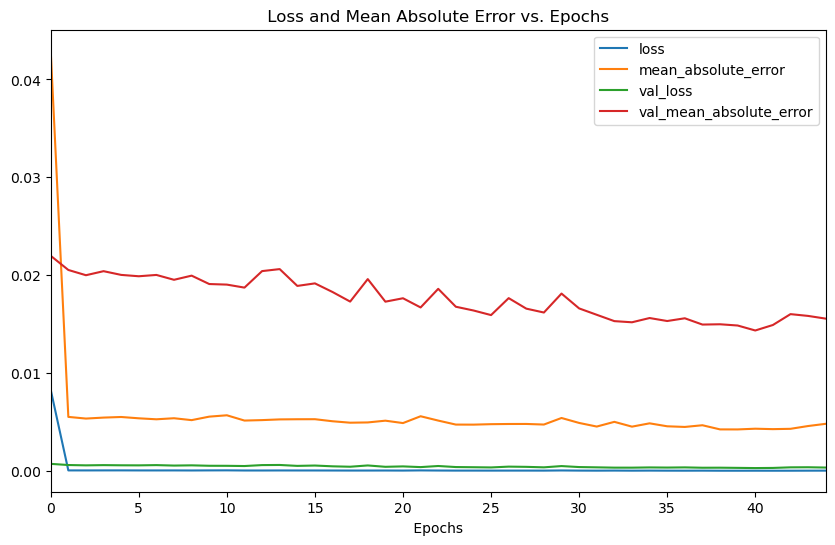

In [52]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
GRU_Model_W6_losses = pd.DataFrame(GRU_Model_W6.history.history)

ax = GRU_Model_W6_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [53]:
highlighted_GRU_Model_W6_losses = highlight_best(GRU_Model_W6_losses)
highlighted_GRU_Model_W6_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.008311,0.042932,0.000753,0.021993
1,0.000084,0.005548,0.000634,0.020548
2,0.000083,0.005377,0.000600,0.020012
3,0.000086,0.005477,0.000624,0.020425
4,0.000087,0.005538,0.000606,0.020044
5,0.000082,0.005403,0.000600,0.019906
6,0.000081,0.005303,0.000625,0.020040
7,0.000083,0.005410,0.000578,0.019545
8,0.000077,0.005217,0.000601,0.019968
9,0.000086,0.005573,0.000558,0.019112


### Evaluation of GRU model on test data

In [55]:
def predict_and_inverse_transform2(DF, X_test, model, scaler):
    
    test = DF.iloc[-len(X_test):].copy()
    
    predictions = model.predict(X_test)
    inverse_predictions = scaler.inverse_transform(predictions)
    inverse_predictions = pd.DataFrame(inverse_predictions,columns=['Predicted Close', 'Predicted High',
                        'Predicted Low', 'Predicted Open'],index=DF.iloc[-len(X_test):].index)
    
    test_df = pd.concat([test.copy(), inverse_predictions], axis=1)
    test_df[['Open', 'High', 'Low', 'Close']] = scaler.inverse_transform(test_df[['Open', 'High', 'Low', 'Close']])
    
    
    return test_df

In [56]:
test_df3_GRU_Model_W6 = predict_and_inverse_transform2(DF, X_test6, GRU_Model_W6, scaler)

8/8 [==============================] - 0s 6ms/step


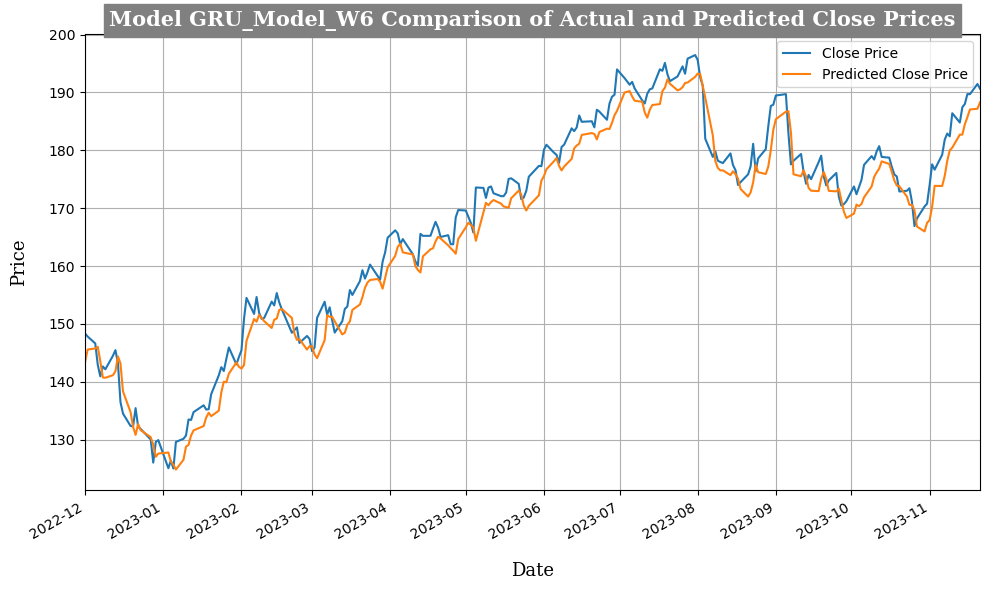

In [116]:
plt.figure(figsize=(10, 6))
test_df3_GRU_Model_W6['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df3_GRU_Model_W6['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model GRU_Model_W6 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()


### Dataset and models for window size = 30 days

In [59]:
X_train30, y_train30 = prepare_time_series_data(train_data,30)
X_test30, y_test30 = prepare_time_series_data(test_data,30)
X_val30, y_val30 = prepare_time_series_data(val_data,30)

In [60]:
X_train30.shape, y_train30.shape, X_test30.shape, y_test30.shape, X_val30.shape, y_val30.shape

((1983, 30, 4), (1983, 4), (221, 30, 4), (221, 4), (222, 30, 4), (222, 4))

### Model 1: Simple LSTM model with window size = 30

In [61]:
length = 30
LSTM1_W30 = Sequential()

# simple RNN layer
LSTM1_W30.add(LSTM(100, return_sequences=True, input_shape=(length, X_train30.shape[2])))
LSTM1_W30.add(Dropout(0.2))
LSTM1_W30.add(LSTM(100, return_sequences=False, input_shape=(length, X_train30.shape[2])))
LSTM1_W30.add(Dropout(0.2))
LSTM1_W30.add(Dense(X_train30.shape[2]))

# compile the model
LSTM1_W30.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [62]:
LSTM1_W30.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 100)           42000     
                                                                 
 dropout_6 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 404       
                                                                 
Total params: 122804 (479.70 KB)
Trainable params: 122804 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
early_stop = EarlyStopping(monitor='loss', patience=5)

In [64]:
# fit the model with 50 epochs
LSTM1_W30.fit(X_train30, y_train30, epochs=50, validation_data=(X_val30, y_val30), batch_size=32, callbacks=[early_stop])

Epoch 1/50
62/62 [==============================] - 3s 34ms/step - loss: 0.0058 - mean_absolute_error: 0.0402 - val_loss: 0.0030 - val_mean_absolute_error: 0.0440
Epoch 2/50
62/62 [==============================] - 1s 19ms/step - loss: 6.7783e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0020 - val_mean_absolute_error: 0.0361
Epoch 3/50
62/62 [==============================] - 1s 19ms/step - loss: 5.0536e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0017 - val_mean_absolute_error: 0.0335
Epoch 4/50
62/62 [==============================] - 1s 19ms/step - loss: 3.6418e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0017 - val_mean_absolute_error: 0.0335
Epoch 5/50
62/62 [==============================] - 1s 18ms/step - loss: 2.9327e-04 - mean_absolute_error: 0.0106 - val_loss: 0.0015 - val_mean_absolute_error: 0.0317
Epoch 6/50
62/62 [==============================] - 1s 18ms/step - loss: 2.3892e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0019 - val_mean_absolute_error: 0.0360
Ep

### Visualising Model Metrics

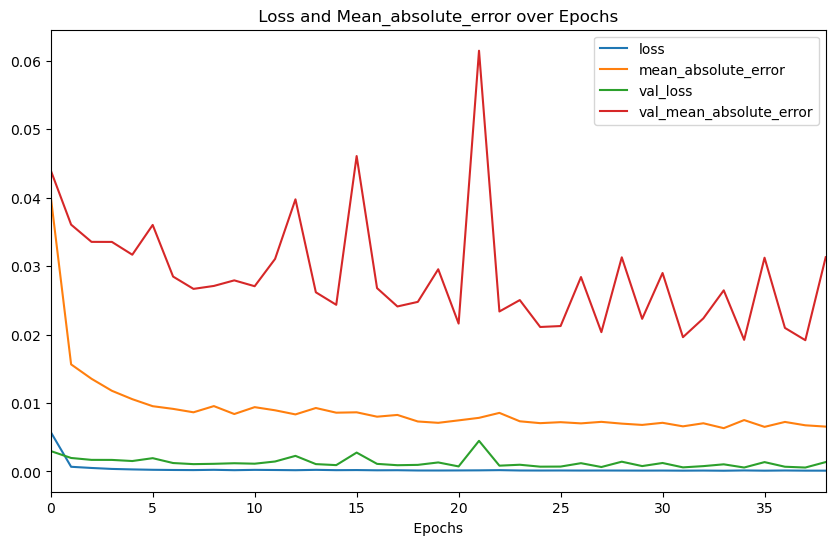

In [65]:
title=' Loss and Mean_absolute_error over Epochs '

xlabel=' Epochs '

LSTM1_W30_losses = pd.DataFrame(LSTM1_W30.history.history)
ax = LSTM1_W30_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [66]:
highlighted_LSTM1_W30_losses = highlight_best(LSTM1_W30_losses)
highlighted_LSTM1_W30_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.005756,0.040179,0.002978,0.043995
1,0.000678,0.015637,0.001965,0.036051
2,0.000505,0.013534,0.001687,0.033534
3,0.000364,0.011778,0.001681,0.033527
4,0.000293,0.010554,0.001519,0.031658
5,0.000239,0.009529,0.001936,0.036008
6,0.000211,0.009138,0.001226,0.028465
7,0.000196,0.008637,0.001066,0.026667
8,0.000235,0.009544,0.001112,0.027097
9,0.000182,0.008385,0.001196,0.027910


In [67]:
test_df_LSTM1_W30 = predict_and_inverse_transform(DF, X_test30, LSTM1_W30, scaler)

7/7 [==============================] - 0s 12ms/step


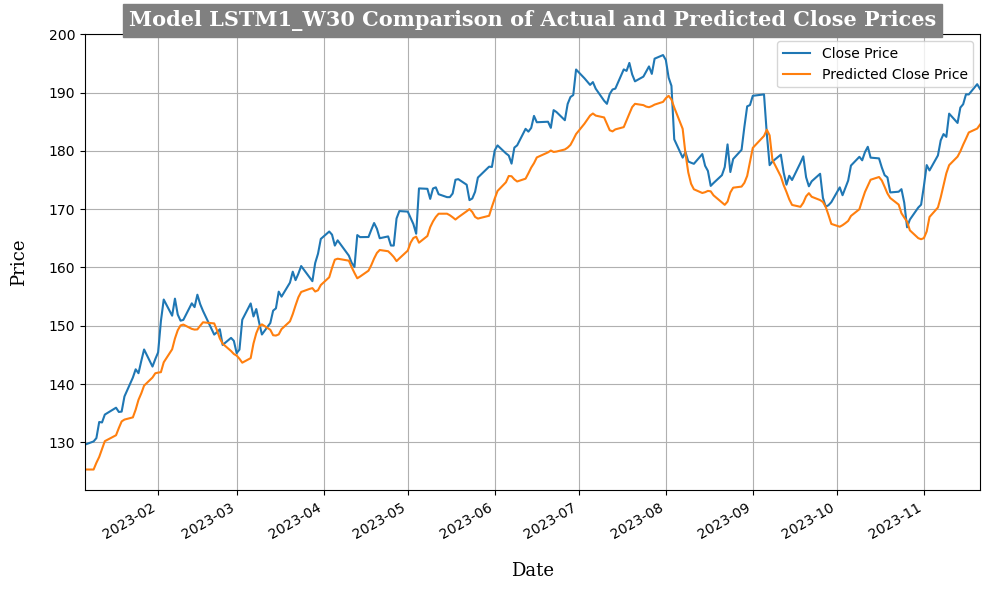

In [110]:
plt.figure(figsize=(10, 6))
test_df_LSTM1_W30['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df_LSTM1_W30['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM1_W30 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()

In [69]:
LSTM2_W30 = Sequential()

# First LSTM layer
LSTM2_W30.add(LSTM(150, input_shape=(length,X_train30.shape[2]), return_sequences=True))
LSTM2_W30.add(Dropout(0.2))

# Second LSTM layer
LSTM2_W30.add(LSTM(100, input_shape=(length,X_train30.shape[2]), return_sequences=True))
LSTM2_W30.add(Dropout(0.2))

# Third LSTM layer 
LSTM2_W30.add(LSTM(100, input_shape=(length,X_train30.shape[2]), return_sequences=False)) 
LSTM2_W30.add(Dropout(0.2))

# Final Prediction (one neuron per feature)
LSTM2_W30.add(Dense(units=50))
LSTM2_W30.add(Dense(units=5))
LSTM2_W30.add(Dense(X_train30.shape[2]))

LSTM2_W30.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [70]:
LSTM2_W30.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 150)           93000     
                                                                 
 dropout_8 (Dropout)         (None, 30, 150)           0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 100)           100400    
                                                                 
 dropout_9 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)               

In [71]:
LSTM2_W30.fit(X_train30, y_train30,epochs=50,validation_data=(X_val30, y_val30),batch_size = 32,callbacks=[early_stop],verbose=1)

Epoch 1/50
62/62 [==============================] - 5s 48ms/step - loss: 0.0046 - mean_absolute_error: 0.0346 - val_loss: 0.0034 - val_mean_absolute_error: 0.0481
Epoch 2/50
62/62 [==============================] - 2s 26ms/step - loss: 5.5138e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0028 - val_mean_absolute_error: 0.0430
Epoch 3/50
62/62 [==============================] - 2s 25ms/step - loss: 6.2431e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0022 - val_mean_absolute_error: 0.0381
Epoch 4/50
62/62 [==============================] - 1s 24ms/step - loss: 5.3990e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0022 - val_mean_absolute_error: 0.0380
Epoch 5/50
62/62 [==============================] - 2s 29ms/step - loss: 3.5137e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0017 - val_mean_absolute_error: 0.0338
Epoch 6/50
62/62 [==============================] - 2s 25ms/step - loss: 2.9360e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0020 - val_mean_absolute_error: 0.0362
Ep

### Visualising model metrics

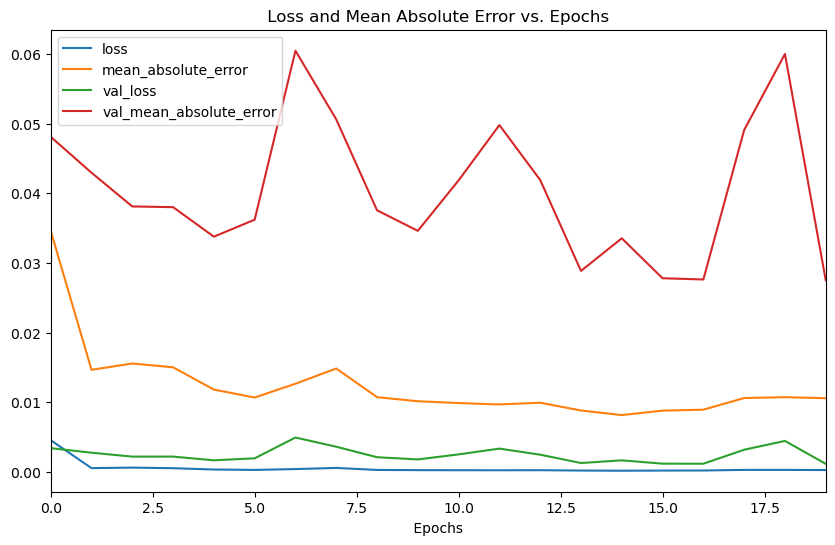

In [72]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
LSTM2_W30_losses = pd.DataFrame(LSTM2_W30.history.history)

ax = LSTM2_W30_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [73]:
highlighted_LSTM2_W30_losses = highlight_best(LSTM2_W30_losses)
highlighted_LSTM2_W30_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.004557,0.034609,0.003415,0.048107
1,0.000551,0.014660,0.002765,0.042954
2,0.000624,0.015568,0.002202,0.038112
3,0.000540,0.015024,0.002204,0.038012
4,0.000351,0.011825,0.001672,0.033774
5,0.000294,0.010682,0.001960,0.036215
6,0.000415,0.012670,0.004945,0.060466
7,0.000580,0.014849,0.003623,0.050609
8,0.000291,0.010739,0.002117,0.037562
9,0.000262,0.010152,0.001797,0.034611


### Evaluation of the second LSTM model on test data

In [74]:
test_df2_LSTM2_W30 = predict_and_inverse_transform(DF, X_test30, LSTM2_W30, scaler)

7/7 [==============================] - 1s 22ms/step


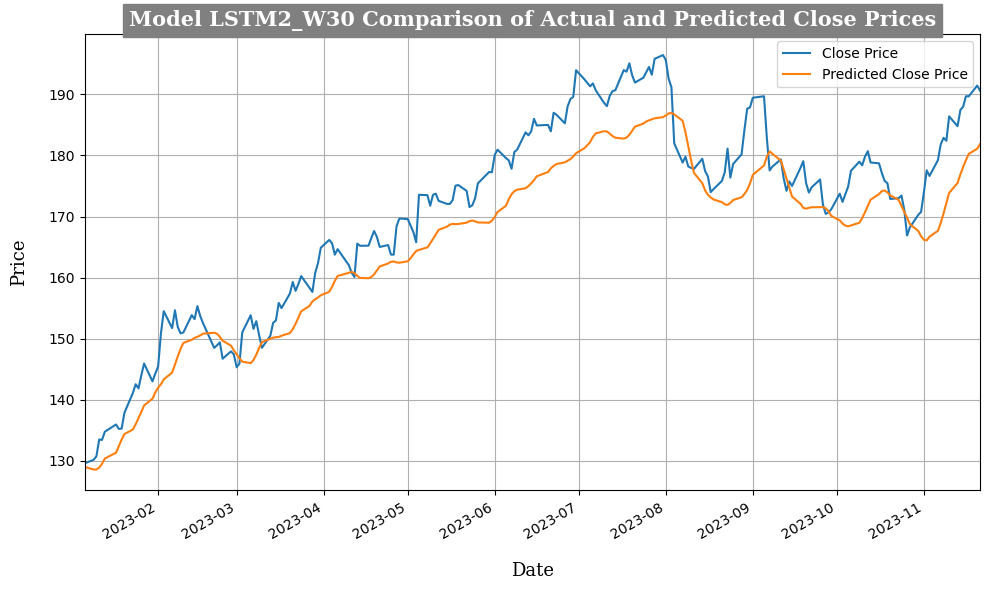

In [111]:
plt.figure(figsize=(10, 6))
test_df2_LSTM2_W30['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df2_LSTM2_W30['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM2_W30 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 3: GRU Model with window size = 30

In [76]:
GRU_Model_W30 = Sequential()

# add a GRU layer with input_shape
GRU_Model_W30.add(GRU(128, input_shape=(length, X_train30.shape[2]), activation='tanh'))

# add the final dense layer
GRU_Model_W30.add(Dense(X_train30.shape[2]))

# compile the model
GRU_Model_W30.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [77]:
GRU_Model_W30.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               51456     
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                                 
Total params: 51972 (203.02 KB)
Trainable params: 51972 (203.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
GRU_Model_W30.fit(X_train30, y_train30, epochs=50,validation_data=(X_val30, y_val30),batch_size = 32,callbacks=[early_stop],verbose=1)


Epoch 1/50
62/62 [==============================] - 2s 22ms/step - loss: 0.0084 - mean_absolute_error: 0.0448 - val_loss: 6.8132e-04 - val_mean_absolute_error: 0.0212
Epoch 2/50
62/62 [==============================] - 1s 13ms/step - loss: 1.0440e-04 - mean_absolute_error: 0.0062 - val_loss: 5.9836e-04 - val_mean_absolute_error: 0.0199
Epoch 3/50
62/62 [==============================] - 1s 13ms/step - loss: 8.1917e-05 - mean_absolute_error: 0.0054 - val_loss: 5.5281e-04 - val_mean_absolute_error: 0.0192
Epoch 4/50
62/62 [==============================] - 1s 14ms/step - loss: 7.8619e-05 - mean_absolute_error: 0.0052 - val_loss: 5.3742e-04 - val_mean_absolute_error: 0.0188
Epoch 5/50
62/62 [==============================] - 1s 13ms/step - loss: 7.5146e-05 - mean_absolute_error: 0.0051 - val_loss: 4.9729e-04 - val_mean_absolute_error: 0.0182
Epoch 6/50
62/62 [==============================] - 1s 14ms/step - loss: 7.7405e-05 - mean_absolute_error: 0.0053 - val_loss: 4.9145e-04 - val_mean_a

### Visualising model metrics

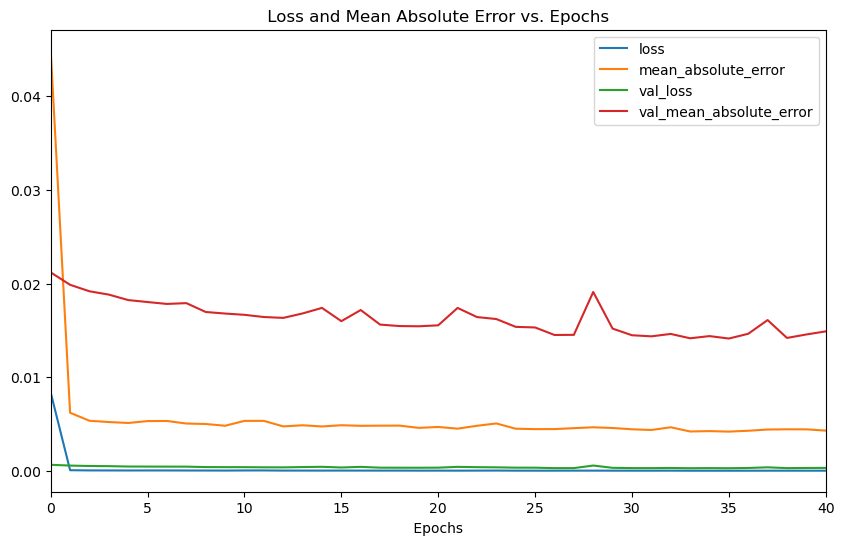

In [80]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
GRU_Model_W30_losses = pd.DataFrame(GRU_Model_W30.history.history)

ax = GRU_Model_W30_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [81]:
highlighted_GRU_Model_W30_losses = highlight_best(GRU_Model_W30_losses)
highlighted_GRU_Model_W30_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.008372,0.044812,0.000681,0.021184
1,0.000104,0.006227,0.000598,0.019864
2,0.000082,0.005375,0.000553,0.019174
3,0.000079,0.005238,0.000537,0.018818
4,0.000075,0.005138,0.000497,0.018236
5,0.000077,0.005341,0.000491,0.018027
6,0.000078,0.005353,0.000486,0.017824
7,0.000072,0.005080,0.000484,0.017911
8,0.000070,0.005029,0.000438,0.016967
9,0.000066,0.004843,0.000431,0.016801


In [82]:
test_df3_GRU_Model_W30 = predict_and_inverse_transform2(DF, X_test30, GRU_Model_W30, scaler)

7/7 [==============================] - 0s 13ms/step


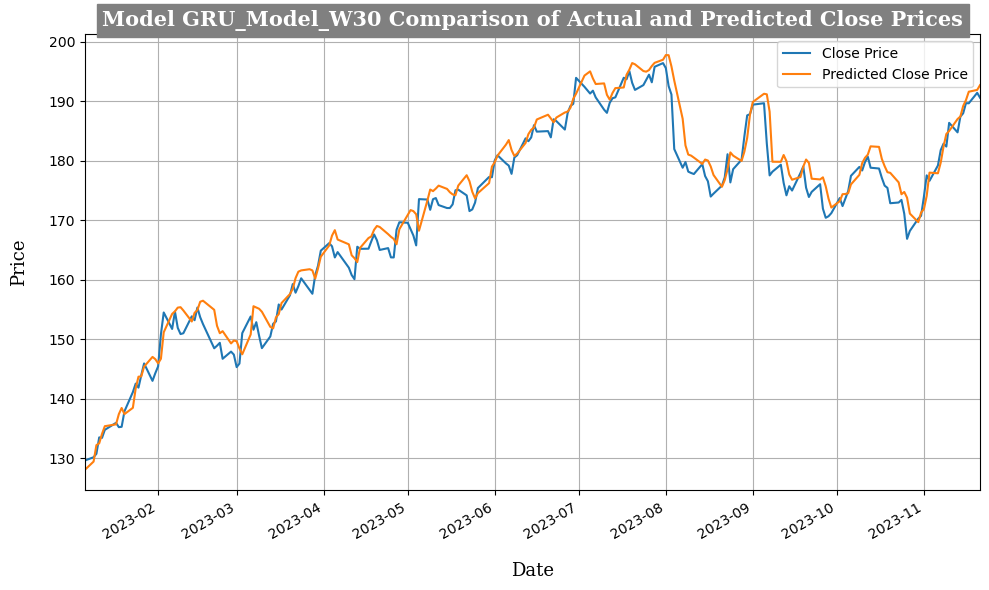

In [112]:
plt.figure(figsize=(10, 6))
test_df3_GRU_Model_W30['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df3_GRU_Model_W30['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model GRU_Model_W30 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()


### Dataset and models for window size = 60 

In [84]:
X_train60, y_train60 = prepare_time_series_data(train_data,60)
X_test60, y_test60 = prepare_time_series_data(test_data,60)
X_val60, y_val60 = prepare_time_series_data(val_data,60)

### Model 1: Simple LSTM model with window size = 60

In [85]:
length = 60
LSTM1_W60 = Sequential()

# simple RNN layer
LSTM1_W60.add(LSTM(100, return_sequences=True, input_shape=(length, X_train60.shape[2])))
LSTM1_W60.add(Dropout(0.2))
LSTM1_W60.add(LSTM(100, return_sequences=False, input_shape=(length, X_train60.shape[2])))
LSTM1_W60.add(Dropout(0.2))
LSTM1_W60.add(Dense(X_train60.shape[2]))

# compile the model
LSTM1_W60.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [86]:
LSTM1_W60.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           42000     
                                                                 
 dropout_11 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 404       
                                                                 
Total params: 122804 (479.70 KB)
Trainable params: 122804 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# fit the model with 50 epochs
LSTM1_W60.fit(X_train60, y_train60, epochs=50, validation_data=(X_val60, y_val60), batch_size=32, callbacks=[early_stop])

Epoch 1/50
62/62 [==============================] - 4s 37ms/step - loss: 0.0049 - mean_absolute_error: 0.0362 - val_loss: 0.0120 - val_mean_absolute_error: 0.0998
Epoch 2/50
62/62 [==============================] - 1s 23ms/step - loss: 0.0015 - mean_absolute_error: 0.0238 - val_loss: 0.0044 - val_mean_absolute_error: 0.0560
Epoch 3/50
62/62 [==============================] - 1s 23ms/step - loss: 4.7681e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0023 - val_mean_absolute_error: 0.0390
Epoch 4/50
62/62 [==============================] - 2s 24ms/step - loss: 3.2830e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0019 - val_mean_absolute_error: 0.0356
Epoch 5/50
62/62 [==============================] - 1s 22ms/step - loss: 3.2310e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0016 - val_mean_absolute_error: 0.0325
Epoch 6/50
62/62 [==============================] - 1s 22ms/step - loss: 2.7114e-04 - mean_absolute_error: 0.0104 - val_loss: 0.0015 - val_mean_absolute_error: 0.0314
Epoch 

### Visualising Model Metrics

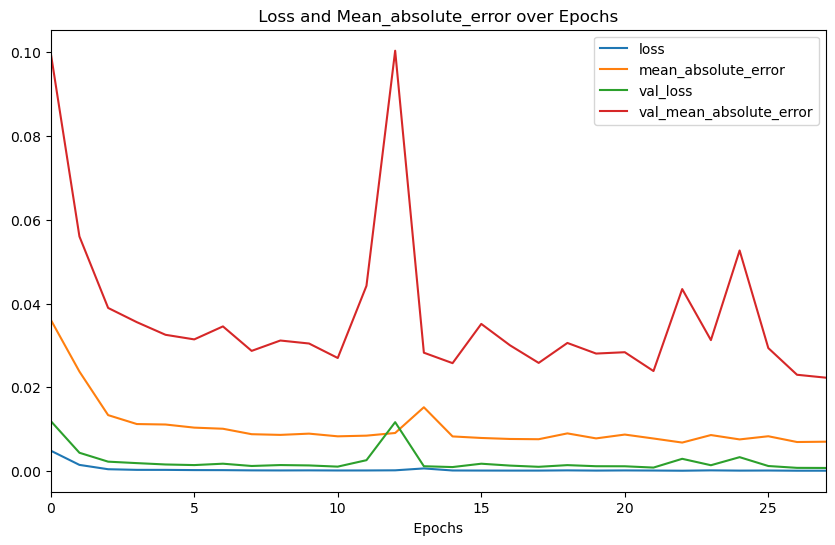

In [88]:
title=' Loss and Mean_absolute_error over Epochs '

xlabel=' Epochs '

LSTM1_W60_losses = pd.DataFrame(LSTM1_W60.history.history)
ax = LSTM1_W60_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [89]:
highlighted_LSTM1_W60_losses = highlight_best(LSTM1_W60_losses)
highlighted_LSTM1_W60_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.004907,0.036151,0.011984,0.099793
1,0.001511,0.023776,0.004405,0.056003
2,0.000477,0.013384,0.002283,0.038951
3,0.000328,0.011255,0.001934,0.035556
4,0.000323,0.011143,0.001611,0.032540
5,0.000271,0.010400,0.001467,0.031446
6,0.000260,0.010134,0.001796,0.034544
7,0.000203,0.008832,0.001252,0.028706
8,0.000188,0.008668,0.001472,0.031177
9,0.000207,0.008966,0.001384,0.030464


In [90]:
test_df_LSTM1_W60 = predict_and_inverse_transform(DF, X_test60, LSTM1_W60, scaler)

6/6 [==============================] - 0s 18ms/step


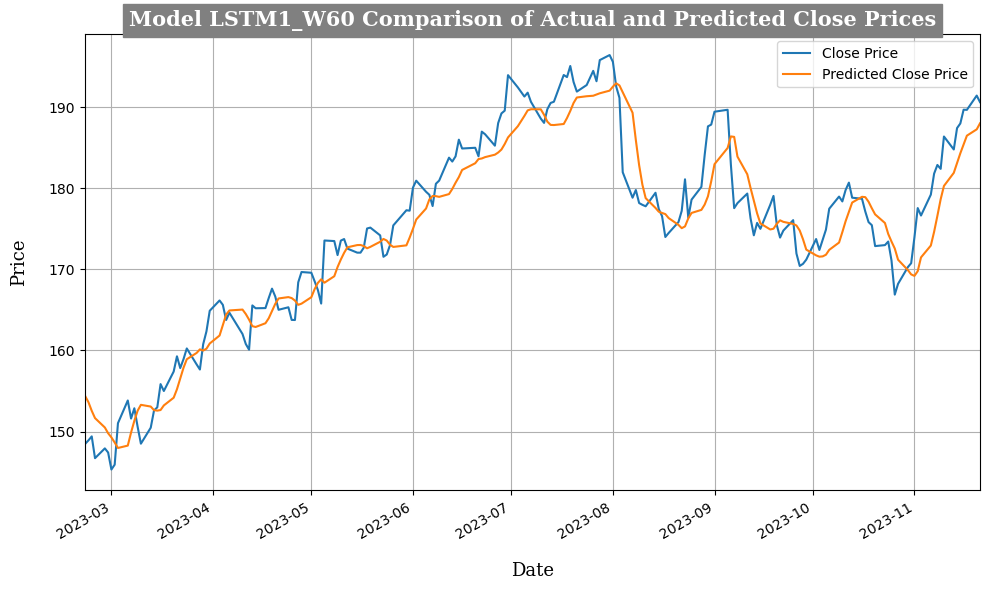

In [113]:
plt.figure(figsize=(10, 6))
test_df_LSTM1_W60['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df_LSTM1_W60['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM1_W60 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()

In [92]:
LSTM2_W60 = Sequential()

# First LSTM layer
LSTM2_W60.add(LSTM(150, input_shape=(length,X_train60.shape[2]), return_sequences=True))
LSTM2_W60.add(Dropout(0.2))

# Second LSTM layer
LSTM2_W60.add(LSTM(100, input_shape=(length,X_train60.shape[2]), return_sequences=True))
LSTM2_W60.add(Dropout(0.2))

# Third LSTM layer 
LSTM2_W60.add(LSTM(100, input_shape=(length,X_train60.shape[2]), return_sequences=False)) 
LSTM2_W60.add(Dropout(0.2))

# Final Prediction (one neuron per feature)
LSTM2_W60.add(Dense(units=50))
LSTM2_W60.add(Dense(units=5))
LSTM2_W60.add(Dense(X_train60.shape[2]))

LSTM2_W60.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [93]:
LSTM2_W60.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 150)           93000     
                                                                 
 dropout_13 (Dropout)        (None, 60, 150)           0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 100)           100400    
                                                                 
 dropout_14 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_16 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 50)               

In [94]:
LSTM2_W60.fit(X_train60, y_train60,epochs=50,validation_data=(X_val60, y_val60),batch_size = 32,callbacks=[early_stop],verbose=1)

Epoch 1/50
62/62 [==============================] - 5s 49ms/step - loss: 0.0068 - mean_absolute_error: 0.0417 - val_loss: 0.0029 - val_mean_absolute_error: 0.0434
Epoch 2/50
62/62 [==============================] - 2s 28ms/step - loss: 8.1188e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0051 - val_mean_absolute_error: 0.0607
Epoch 3/50
62/62 [==============================] - 2s 27ms/step - loss: 5.4428e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0025 - val_mean_absolute_error: 0.0416
Epoch 4/50
62/62 [==============================] - 2s 27ms/step - loss: 4.2786e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0049 - val_mean_absolute_error: 0.0584
Epoch 5/50
62/62 [==============================] - 2s 28ms/step - loss: 4.5300e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0046 - val_mean_absolute_error: 0.0569
Epoch 6/50
62/62 [==============================] - 2s 27ms/step - loss: 3.6222e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0022 - val_mean_absolute_error: 0.0384
Ep

### Visualising model metrics

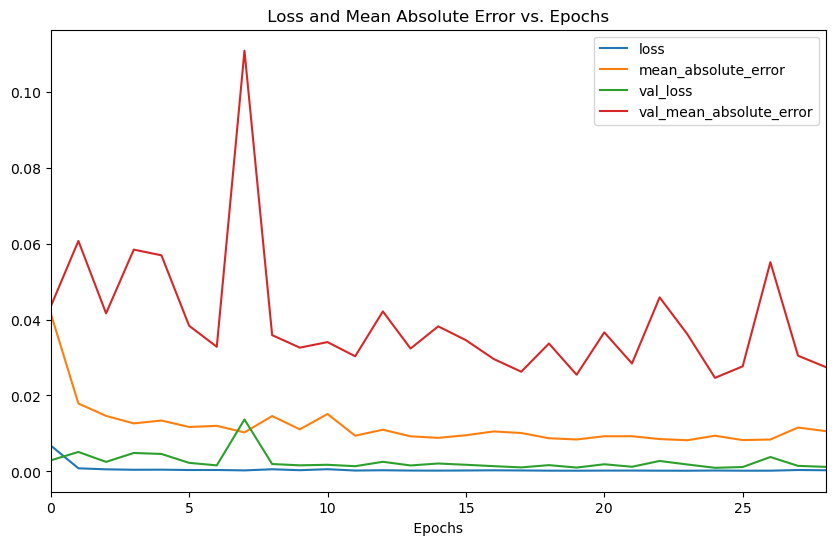

In [95]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
LSTM2_W60_losses = pd.DataFrame(LSTM2_W60.history.history)

ax = LSTM2_W60_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [96]:
highlighted_LSTM2_W60_losses = highlight_best(LSTM2_W60_losses)
highlighted_LSTM2_W60_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.006816,0.041662,0.002912,0.043435
1,0.000812,0.017884,0.005120,0.060721
2,0.000544,0.014626,0.002506,0.041639
3,0.000428,0.012647,0.004854,0.058428
4,0.000453,0.013401,0.004596,0.056932
5,0.000362,0.011702,0.002250,0.038366
6,0.000368,0.012003,0.001586,0.032829
7,0.000265,0.010271,0.013675,0.110831
8,0.000558,0.014583,0.001939,0.035898
9,0.000315,0.011080,0.001601,0.032604


In [97]:
test_df2_LSTM2_W60 = predict_and_inverse_transform(DF, X_test60, LSTM2_W60, scaler)

6/6 [==============================] - 1s 29ms/step


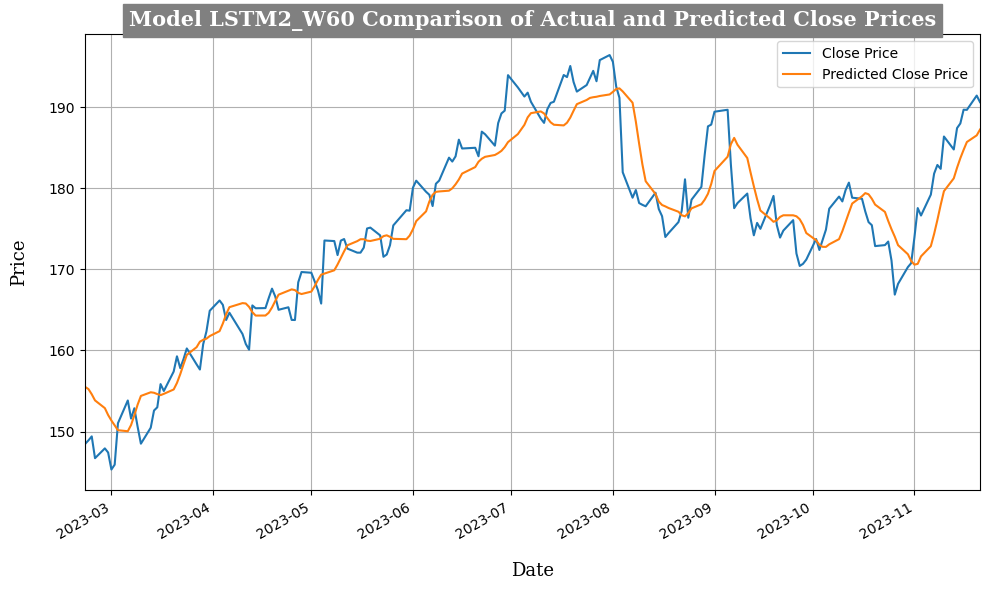

In [114]:
plt.figure(figsize=(10, 6))
test_df2_LSTM2_W60['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df2_LSTM2_W60['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model LSTM2_W60 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 3: GRU Model with window size = 60

In [99]:
GRU_Model_W60 = Sequential()

# add a GRU layer with input_shape
GRU_Model_W60.add(GRU(128, input_shape=(length, X_train60.shape[2]), activation='tanh'))

# add the final dense layer
GRU_Model_W60.add(Dense(X_train60.shape[2]))

# compile the model
GRU_Model_W60.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [100]:
GRU_Model_W60.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128)               51456     
                                                                 
 dense_15 (Dense)            (None, 4)                 516       
                                                                 
Total params: 51972 (203.02 KB)
Trainable params: 51972 (203.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
GRU_Model_W60.fit(X_train60, y_train60, epochs=50,validation_data=(X_val60, y_val60),batch_size = 32,callbacks=[early_stop],verbose=1)


Epoch 1/50
62/62 [==============================] - 2s 26ms/step - loss: 0.0088 - mean_absolute_error: 0.0447 - val_loss: 8.8445e-04 - val_mean_absolute_error: 0.0239
Epoch 2/50
62/62 [==============================] - 1s 18ms/step - loss: 9.4219e-05 - mean_absolute_error: 0.0058 - val_loss: 5.7688e-04 - val_mean_absolute_error: 0.0197
Epoch 3/50
62/62 [==============================] - 1s 17ms/step - loss: 8.4731e-05 - mean_absolute_error: 0.0055 - val_loss: 7.0253e-04 - val_mean_absolute_error: 0.0209
Epoch 4/50
62/62 [==============================] - 1s 17ms/step - loss: 8.0361e-05 - mean_absolute_error: 0.0053 - val_loss: 5.2743e-04 - val_mean_absolute_error: 0.0186
Epoch 5/50
62/62 [==============================] - 1s 17ms/step - loss: 7.6157e-05 - mean_absolute_error: 0.0052 - val_loss: 5.0270e-04 - val_mean_absolute_error: 0.0183
Epoch 6/50
62/62 [==============================] - 1s 17ms/step - loss: 7.5586e-05 - mean_absolute_error: 0.0051 - val_loss: 5.5328e-04 - val_mean_a

### Visualising model metrics

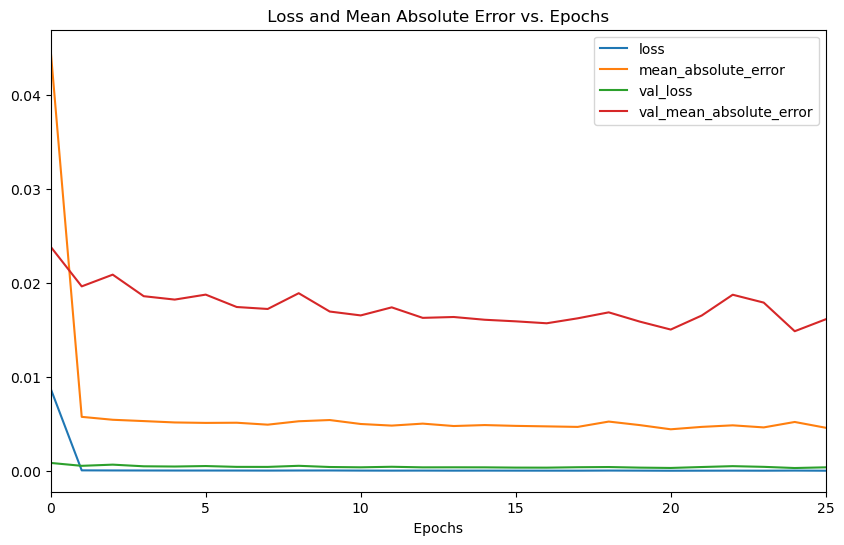

In [102]:
title=' Loss and Mean Absolute Error vs. Epochs '
xlabel=' Epochs '
GRU_Model_W60_losses = pd.DataFrame(GRU_Model_W60.history.history)

ax = GRU_Model_W60_losses.plot(figsize=(10,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel);

In [103]:
highlighted_GRU_Model_W60_losses = highlight_best(GRU_Model_W60_losses)
highlighted_GRU_Model_W60_losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.008773,0.044747,0.000884,0.023884
1,0.000094,0.005788,0.000577,0.019672
2,0.000085,0.005478,0.000703,0.020920
3,0.000080,0.005338,0.000527,0.018627
4,0.000076,0.005192,0.000503,0.018266
5,0.000076,0.005144,0.000553,0.018794
6,0.000074,0.005162,0.000465,0.017477
7,0.000070,0.004956,0.000462,0.017268
8,0.000079,0.005319,0.000579,0.018944
9,0.000082,0.005449,0.000452,0.016994


In [104]:
test_df3_GRU_Model_W60 = predict_and_inverse_transform2(DF, X_test60, GRU_Model_W60, scaler)

6/6 [==============================] - 0s 17ms/step


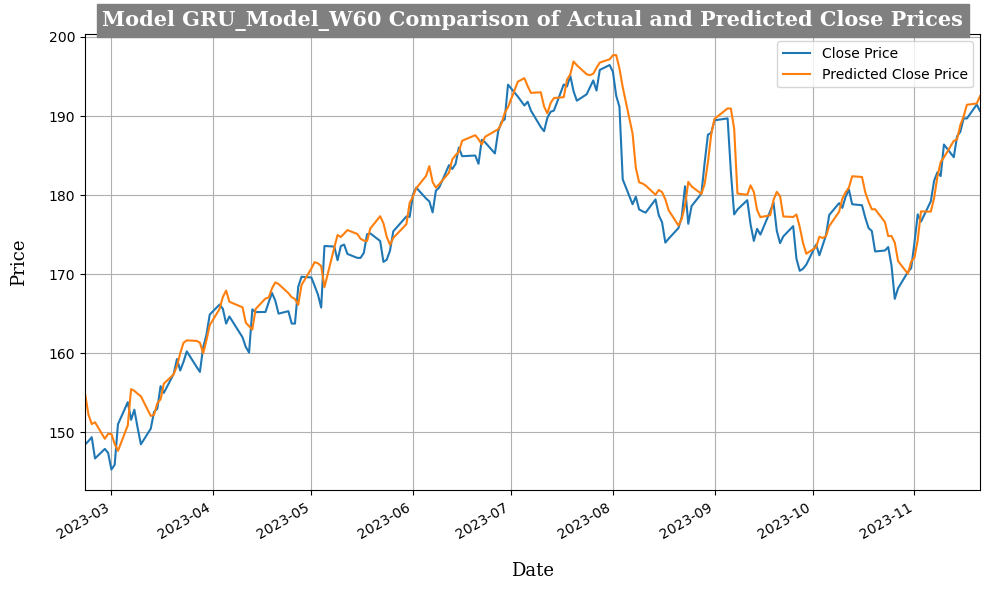

In [115]:
plt.figure(figsize=(10, 6))
test_df3_GRU_Model_W60['Close'].plot(label='Close Price').autoscale(axis='x',tight=True)
test_df3_GRU_Model_W60['Predicted Close'].plot(label='Predicted Close Price').autoscale(axis='x',tight=True)

plt.legend()
plt.title('Model GRU_Model_W60 Comparison of Actual and Predicted Close Prices',backgroundcolor='grey',color='white',fontdict=font2, fontweight='bold')  
plt.xlabel('Date',fontdict=font3,labelpad=15)
plt.ylabel('Price',fontdict=font3,labelpad=15)
plt.grid(True)
plt.tight_layout()
